In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import scikitplot as sckplt
import time
import re
import scipy.stats as stat
from math import sqrt
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import linear_model, tree, neighbors, svm, ensemble
from sklearn.metrics import precision_score, make_scorer

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [2]:
# setting OS directory
os.chdir('C:\\Users\\rckar\\OneDrive\\Documents\\MSBA\\Fall Semester\\6420 Predictive Analytics\\HW3')

In [3]:
# Reading Data
df = pd.read_csv("spambase.data", header=None)

col_names = ["word_freq_make","word_freq_address","word_freq_all",
"word_freq_3d","word_freq_our","word_freq_over","word_freq_remove","word_freq_internet","word_freq_order","word_freq_mail",
"word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses","word_freq_free","word_freq_business",
"word_freq_email","word_freq_you","word_freq_credit","word_freq_your","word_freq_font","word_freq_000","word_freq_money",
"word_freq_hp","word_freq_hpl","word_freq_george","word_freq_650","word_freq_lab","word_freq_labs","word_freq_telnet",
"word_freq_857","word_freq_data","word_freq_415","word_freq_85","word_freq_technology","word_freq_1999","word_freq_parts",
"word_freq_pm","word_freq_direct","word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project","word_freq_re",
"word_freq_edu","word_freq_table","word_freq_conference","char_freq_;","char_freq_(","char_freq_[","char_freq_!","char_freq_$",
"char_freq_#","capital_run_length_average","capital_run_length_longest","capital_run_length_total","class"
]

df.columns = col_names

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq__,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.0,0.778,0.00,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.0,0.94,...,0.0,0.132,0.0,0.372,0.18,0.048,5.114,101,1028,1


In [4]:
# Data pre-processing

# checking for null values
df.isnull().values.any()

False

In [5]:
# Selecting required columns
X_df = df.iloc[:,0:57]
y_df = df.iloc[:,57]

##### Creating the Train and Test split

In [6]:
X_train, X_test_holdout, y_train, y_test_holdout = train_test_split(X_df, y_df, test_size=0.25, random_state=42)

##### Normalizing Data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test_holdout)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [8]:
cost = [[0,10],[1,0]]
def calc_cost(matrix,cost):
    return ((matrix*cost).sum())

In [9]:
custom_scorer = make_scorer(precision_score, greater_is_better=True,  pos_label=1)

### Checking effect of Normalizing data using KNN and Logistic

In [10]:
print("non-normalized data")
print(" ")

print("Logistic Regression")
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring='accuracy')
grid_logistic.fit(X_train,y_train)

clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train, y_train, cv=5)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_logistic_best.fit(X_train,y_train)
y_pred = clf_logistic_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

# KNN
print(" ")
print("KNN")
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring='accuracy')
grid_knn.fit(X_train,y_train)

clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_knn_best.fit(X_train,y_train)
y_pred = clf_knn_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

#Decision Tree
print(" ")
print("Decision Tree")

clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train,y_train)

clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_Dtree_best.fit(X_train,y_train)
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

print(" ")
print(" ")
print("Normalized data")
print(" ")

print("Logistic Regression")
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring='accuracy')
grid_logistic.fit(X_train_scaled,y_train)

clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train_scaled, y_train, cv=5)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_logistic_best.fit(X_train_scaled,y_train)
y_pred = clf_logistic_best.predict(X_test_scaled)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

# KNN
print(" ")
print("KNN")
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled,y_train)

clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train_scaled, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_knn_best.fit(X_train_scaled,y_train)
y_pred = clf_knn_best.predict(X_test_scaled)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

#Decision Tree
print(" ")
print("Decision Tree")

clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train_scaled,y_train)

clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train_scaled, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_Dtree_best.fit(X_train_scaled,y_train)
y_pred = clf_Dtree_best.predict(X_test_scaled)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

non-normalized data
 
Logistic Regression
Mean Accuracy and variance on training data: 0.93 (+/- 0.01)
Accuracy on test data is  92.88 %
 
KNN
Mean Accuracy and variance on training data: 0.82 (+/- 0.04)
Accuracy on test data is  80.02 %
 
Decision Tree
Mean Accuracy and variance on training data: 0.92 (+/- 0.03)
Accuracy on test data is  91.57 %
 
 
Normalized data
 
Logistic Regression
Mean Accuracy and variance on training data: 0.92 (+/- 0.02)
Accuracy on test data is  91.83 %
 
KNN
Mean Accuracy and variance on training data: 0.91 (+/- 0.03)
Accuracy on test data is  89.75 %
 
Decision Tree
Mean Accuracy and variance on training data: 0.92 (+/- 0.03)
Accuracy on test data is  89.14 %


Hence Normalization for Distance based models
and non-normalized data for other models

## Considering Accuracy

## Logistic Regression

In [11]:
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring='accuracy')
grid_logistic.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_logistic.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_logistic.best_params_)

print(" ")
print("Best estimator")
print (grid_logistic.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_logistic_best.fit(X_train,y_train)
print(" ")
y_pred = clf_logistic_best.predict(X_test_holdout)
print("Logistic : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Logistic : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Logistic : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9266666666666666
 
Best parameters
{'C': 0.8000000000000003, 'class_weight': None, 'penalty': 'l1'}
 
Best estimator
LogisticRegression(C=0.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.92474674 0.9146165  0.93188406 0.93613933 0.92597968]
 
Mean Accuracy and variance: 0.93 (+/- 0.01)
 
Logistic : accuracy on test data is  92.88 %
 
Logistic : Confusion Matrix
 
[[652  24]
 [ 58 417]]
 
Logistic : Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       676
           1       0.95      0.88      0.91       475

   micro avg       0.93      0.93      0.93      1151
   macro avg       0.93      0.92

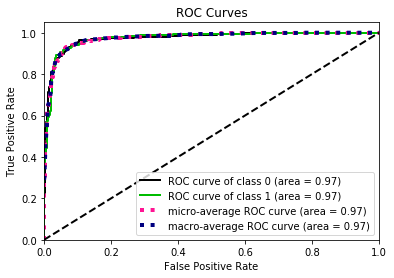

In [12]:
y_probas =  clf_logistic_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

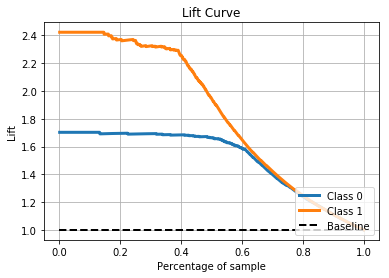

In [13]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## KNN

In [14]:
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_knn.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_knn.best_params_)

print(" ")
print("Best estimator")
print (grid_knn.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_knn_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_knn_best.predict(X_test_scaled)
print("KNN : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("KNN : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("KNN : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9113043478260869
 
Best parameters
{'n_neighbors': 8, 'weights': 'distance'}
 
Best estimator
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='distance')
 
cross-validation results
Below are the scores for each model run
[0.9146165  0.90593343 0.90724638 0.92307692 0.90566038]
 
Mean Accuracy and variance: 0.91 (+/- 0.01)
 
KNN : accuracy on test data is  89.75 %
 
KNN : Confusion Matrix
 
[[614  62]
 [ 56 419]]
 
KNN : Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       676
           1       0.87      0.88      0.88       475

   micro avg       0.90      0.90      0.90      1151
   macro avg       0.89      0.90      0.89      1151
weighted avg       0.90      0.90      0.90      1151

Average Misclassification cost on test data is  676


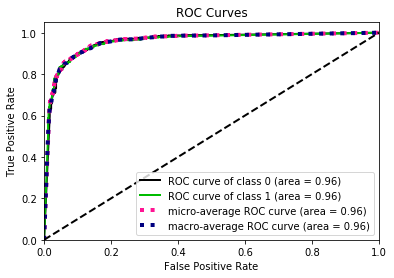

In [15]:
y_probas =  clf_knn_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

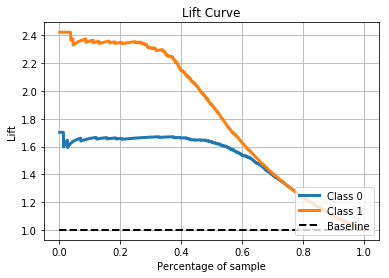

In [16]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Decision Tree

In [17]:
clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_DTree.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_DTree.best_params_)

print(" ")
print("Best estimator")
print (grid_DTree.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_Dtree_best.fit(X_train,y_train)
print(" ")
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Decision Tree : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Decision Tree : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Decision Tree : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9281159420289855
 
Best parameters
{'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 10}
 
Best estimator
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
 
cross-validation results
Below are the scores for each model run
[0.95224313 0.91606368 0.91304348 0.93033382 0.9245283 ]
 
Mean Accuracy and variance: 0.93 (+/- 0.03)
 
Decision Tree : accuracy on test data is  91.57 %
 
Decision Tree : Confusion Matrix
 
[[649  27]
 [ 70 405]]
 
Decision Tree : Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       676
           1       0.94      0.85      0.89       47

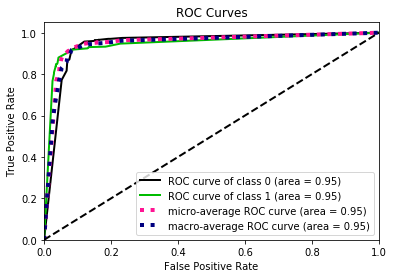

In [18]:
y_probas =  clf_Dtree_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

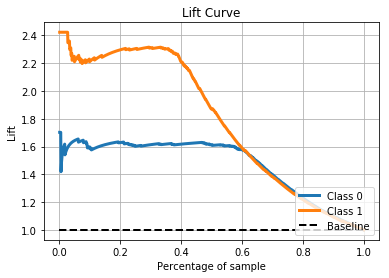

In [19]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Support Vector classification

In [20]:
clf_SVC = svm.SVC(probability=True)

# Hyper parameter tuning using GridSearch
param_set = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1,2,3,4,5,10,100]},
                    {'kernel': ['linear'], 'C': [1,2,3,5,10,100]}]
grid_SVC = GridSearchCV(clf_SVC, param_grid = param_set, cv=5, scoring='accuracy')
grid_SVC.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_SVC.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_SVC.best_params_)

print(" ")
print("Best estimator")
print (grid_SVC.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_SVC_best = grid_SVC.best_estimator_
scores = cross_val_score(clf_SVC_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_SVC_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_SVC_best.predict(X_test_scaled)
print("SVC : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("SVC : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("SVC : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.928695652173913
 
Best parameters
{'C': 100, 'kernel': 'linear'}
 
Best estimator
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
 
cross-validation results
Below are the scores for each model run
[0.92040521 0.9146165  0.93333333 0.94629898 0.92888244]
 
Mean Accuracy and variance: 0.93 (+/- 0.02)
 
SVC : accuracy on test data is  92.27 %
 
SVC : Confusion Matrix
 
[[616  60]
 [ 29 446]]
 
SVC : Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       676
           1       0.88      0.94      0.91       475

   micro avg       0.92      0.92      0.92      1151
   macro avg       0.92      0.93      0.92      1151
weighted avg       0.92      0.92      0.92      1151

Average Misclas

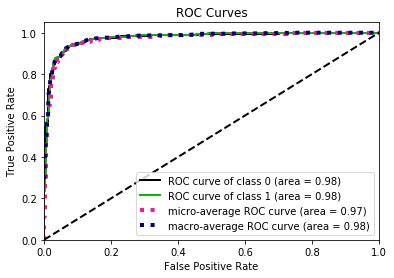

In [21]:
y_probas =  clf_SVC_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

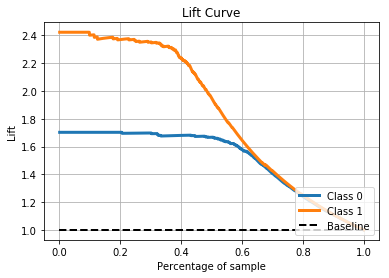

In [22]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Ensemble model : Random Forest

In [23]:
start = time.process_time()
RF = ensemble.RandomForestClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': [3,10,20],
            'min_samples_split' :[4, 5,10],
            'n_estimators': [100, 250],
            'bootstrap':[True, False] ,
            'max_features':['auto', 'sqrt'],
            'n_jobs': [-1]
           }
grid_RF = GridSearchCV(RF, param_grid = param_set, cv=5, scoring='accuracy')
grid_RF.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_RF.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_RF.best_params_)

print(" ")
print("Best estimator")
print (grid_RF.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_RF_best = grid_RF.best_estimator_
scores = cross_val_score(clf_RF_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_RF_best.fit(X_train,y_train)
print(" ")
y_pred = clf_RF_best.predict(X_test_holdout)
print("Random Forest : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Random Forest : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Random Forest : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print(" ")
print('Time Taken = ', time.process_time() - start)

Best score achieved across all parameters:  0.9504347826086956
 
Best parameters
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250, 'n_jobs': -1}
 
Best estimator
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.95224313 0.93777135 0.94347826 0.95355588 0.9521045 ]
 
Mean Accuracy and variance: 0.95 (+/- 0.01)
 
Random Forest : accuracy on test data is  95.74 %
 
Random Forest : Confusion Matrix
 
[[664  12]
 [ 37 438]]
 
Random Forest : Classification Report
              precision    recall  f1

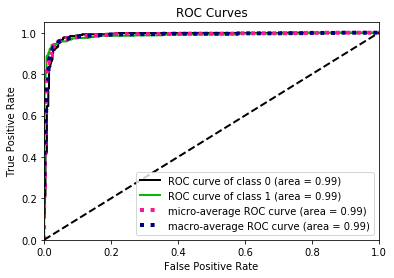

In [24]:
y_probas =  clf_RF_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

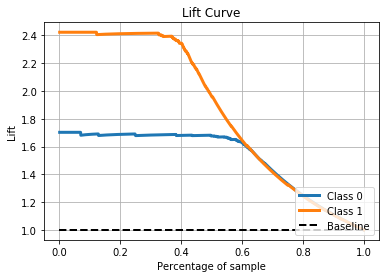

In [25]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Ensemble model : XGBoost

In [27]:
start = time.process_time()
XGB = xgboost.XGBClassifier(nthreads=-1)

a = stat.beta(10, 1)

# Hyper parameter tuning using GridSearch
param_set ={"n_estimators": stat.randint(3, 40),
            "max_depth": stat.randint(3, 40),
            "learning_rate": stat.uniform(0.05, 0.4),
            "colsample_bytree": a,
            "subsample": a,
            "gamma": stat.uniform(0, 10),
            'n_jobs':[-1]
           }

grid_XGB = RandomizedSearchCV(XGB, param_set, cv=5, scoring='accuracy')
grid_XGB.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", abs(grid_XGB.best_score_))

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_XGB.best_params_)

print(" ")
print("Best estimator")
print (grid_XGB.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_XGB_best = grid_XGB.best_estimator_
scores = cross_val_score(clf_XGB_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_XGB_best.fit(X_train,y_train)
print(" ")
y_pred = clf_XGB_best.predict(X_test_holdout)
print("XGBoost : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("XGBoost : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("XGBoost : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print('Time Taken = ', time.process_time() - start)

Best score achieved across all parameters:  0.9489855072463768
 
Best parameters
{'colsample_bytree': 0.890158128676784, 'gamma': 0.07400691836841666, 'learning_rate': 0.41896377833828796, 'max_depth': 33, 'n_estimators': 25, 'n_jobs': -1, 'subsample': 0.9240654205802239}
 
Best estimator
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.890158128676784,
       gamma=0.07400691836841666, learning_rate=0.41896377833828796,
       max_delta_step=0, max_depth=33, min_child_weight=1, missing=None,
       n_estimators=25, n_jobs=-1, nthread=None, nthreads=-1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9240654205802239, verbosity=1)
 
cross-validation results
Below are the scores for each model run
[0.95947902 0.93487699 0.94057971 0.95936139 0.95065312]
 
Mean Accuracy and variance: 0.95 (+/- 0.02)
 
XGBoost : accuracy on 

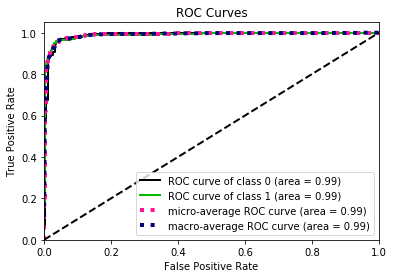

In [28]:
y_probas =  clf_XGB_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

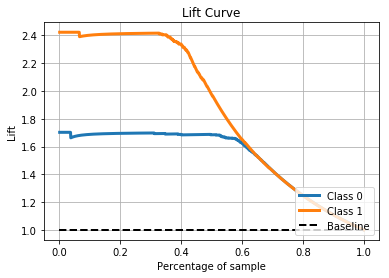

In [29]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Neural Network

##### Shallow network

In [30]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(114, activation = 'relu', input_dim=57))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3450/3450 [==============================] - 0s 140us/step - loss: 0.8878 - accuracy: 0.7159
Epoch 2/100
3450/3450 [==============================] - 0s 56us/step - loss: 0.4614 - accuracy: 0.8580
Epoch 3/100
3450/3450 [==============================] - 0s 54us/step - loss: 0.3203 - accuracy: 0.8907
Epoch 4/100
3450/3450 [==============================] - 0s 55us/step - loss: 0.3056 - accuracy: 0.8983
Epoch 5/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.3809 - accuracy: 0.8806
Epoch 6/100
3450/3450 [==============================] - 0s 56us/step - loss: 0.2666 - accuracy: 0.9110
Epoch 7/100
3450/3450 [==============================] - 0s 58us/step - loss: 0.3892 - accuracy: 0.8826
Epoch 8/100
3450/3450 [==============================] - 0s 56us/step - loss: 0.3474 - accuracy: 0.8948
Epoch 9/100
3450/3450 [========================

3450/3450 [==============================] - 0s 55us/step - loss: 0.2527 - accuracy: 0.9365
Epoch 74/100
3450/3450 [==============================] - 0s 53us/step - loss: 0.2036 - accuracy: 0.9441
Epoch 75/100
3450/3450 [==============================] - 0s 53us/step - loss: 0.2413 - accuracy: 0.9406
Epoch 76/100
3450/3450 [==============================] - 0s 53us/step - loss: 0.1844 - accuracy: 0.9443
Epoch 77/100
3450/3450 [==============================] - 0s 63us/step - loss: 0.1765 - accuracy: 0.9435
Epoch 78/100
3450/3450 [==============================] - 0s 34us/step - loss: 0.2375 - accuracy: 0.9435
Epoch 79/100
3450/3450 [==============================] - 0s 49us/step - loss: 0.1875 - accuracy: 0.9449
Epoch 80/100
3450/3450 [==============================] - 0s 58us/step - loss: 0.3500 - accuracy: 0.9235
Epoch 81/100
3450/3450 [==============================] - 0s 55us/step - loss: 0.2017 - accuracy: 0.9455
Epoch 82/100
3450/3450 [==============================] - 0s 58us/st

In [31]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  93.83 %
 
Neural Network : Confusion Matrix
 
[[631  45]
 [ 26 449]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       676
           1       0.91      0.95      0.93       475

   micro avg       0.94      0.94      0.94      1151
   macro avg       0.93      0.94      0.94      1151
weighted avg       0.94      0.94      0.94      1151

Average Misclassification cost on test data is  476


##### Medium Deep Network

In [32]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(57, activation = 'relu', input_dim=57))
NN.add(Dense(57, activation = 'relu'))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Epoch 1/100
3450/3450 [==============================] - 1s 158us/step - loss: 1.0049 - accuracy: 0.6475
Epoch 2/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.8420 - accuracy: 0.7704
Epoch 3/100
3450/3450 [==============================] - 0s 61us/step - loss: 0.4284 - accuracy: 0.8617
Epoch 4/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.3986 - accuracy: 0.8748
Epoch 5/100
3450/3450 [==============================] - 0s 58us/step - loss: 0.7116 - accuracy: 0.8354
Epoch 6/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.3739 - accuracy: 0.8957
Epoch 7/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.8095 - accuracy: 0.8365
Epoch 8/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.4753 - accuracy: 0.8849
Epoch 9/100
3450/3450 [==============================] - 0s 68us/step - loss: 0.5671 - accuracy: 0.8771
Epoch 10/100
3450/3450 [==============================] - 0s 60

3450/3450 [==============================] - 0s 61us/step - loss: 0.1752 - accuracy: 0.9461
Epoch 80/100
3450/3450 [==============================] - 0s 57us/step - loss: 0.1413 - accuracy: 0.9539
Epoch 81/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.1503 - accuracy: 0.9504
Epoch 82/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.2489 - accuracy: 0.9328
Epoch 83/100
3450/3450 [==============================] - 0s 58us/step - loss: 0.2374 - accuracy: 0.9394
Epoch 84/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.1978 - accuracy: 0.9423
Epoch 85/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.1483 - accuracy: 0.9481
Epoch 86/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.1654 - accuracy: 0.9493
Epoch 87/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.1700 - accuracy: 0.9461
Epoch 88/100
3450/3450 [==============================] - 0s 62us/st

In [33]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  94.44 %
 
Neural Network : Confusion Matrix
 
[[656  20]
 [ 44 431]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       676
           1       0.96      0.91      0.93       475

   micro avg       0.94      0.94      0.94      1151
   macro avg       0.95      0.94      0.94      1151
weighted avg       0.94      0.94      0.94      1151

Average Misclassification cost on test data is  244


##### Deep Network

In [34]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(25, activation = 'relu', input_dim=57))
NN.add(Dense(25, activation = 'relu'))
NN.add(Dense(25, activation = 'relu'))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Epoch 1/100
3450/3450 [==============================] - 1s 182us/step - loss: 0.6918 - accuracy: 0.6832
Epoch 2/100
3450/3450 [==============================] - 0s 65us/step - loss: 0.5438 - accuracy: 0.8046
Epoch 3/100
3450/3450 [==============================] - 0s 65us/step - loss: 0.3809 - accuracy: 0.8693
Epoch 4/100
3450/3450 [==============================] - 0s 64us/step - loss: 0.3449 - accuracy: 0.8774
Epoch 5/100
3450/3450 [==============================] - 0s 68us/step - loss: 0.3989 - accuracy: 0.8638
Epoch 6/100
3450/3450 [==============================] - 0s 65us/step - loss: 0.4119 - accuracy: 0.8646
Epoch 7/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.2828 - accuracy: 0.8925
Epoch 8/100
3450/3450 [==============================] - 0s 61us/step - loss: 0.4752 - accuracy: 0.8670
Epoch 9/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.3204 - accuracy: 0.8901
Epoch 10/100
3450/3450 [==============================] - 0s 65

3450/3450 [==============================] - 0s 66us/step - loss: 0.1457 - accuracy: 0.9525
Epoch 80/100
3450/3450 [==============================] - 0s 63us/step - loss: 0.1447 - accuracy: 0.9513
Epoch 81/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.1753 - accuracy: 0.9406
Epoch 82/100
3450/3450 [==============================] - 0s 66us/step - loss: 0.1701 - accuracy: 0.9438
Epoch 83/100
3450/3450 [==============================] - 0s 65us/step - loss: 0.1458 - accuracy: 0.9484
Epoch 84/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.1888 - accuracy: 0.9362
Epoch 85/100
3450/3450 [==============================] - 0s 74us/step - loss: 0.1387 - accuracy: 0.9513
Epoch 86/100
3450/3450 [==============================] - 0s 64us/step - loss: 0.1971 - accuracy: 0.9330
Epoch 87/100
3450/3450 [==============================] - 0s 64us/step - loss: 0.1321 - accuracy: 0.9542
Epoch 88/100
3450/3450 [==============================] - 0s 68us/st

In [35]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  90.44 %
 
Neural Network : Confusion Matrix
 
[[581  95]
 [ 15 460]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       676
           1       0.83      0.97      0.89       475

   micro avg       0.90      0.90      0.90      1151
   macro avg       0.90      0.91      0.90      1151
weighted avg       0.91      0.90      0.91      1151

Average Misclassification cost on test data is  965


## Considering cost of misclassification error

## Logistic Regression

In [36]:
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring=custom_scorer)
grid_logistic.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_logistic.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_logistic.best_params_)

print(" ")
print("Best estimator")
print (grid_logistic.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_logistic_best.fit(X_train,y_train)
print(" ")
y_pred = clf_logistic_best.predict(X_test_holdout)
print("Logistic : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Logistic : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Logistic : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9460170016189136
 
Best parameters
{'C': 0.2, 'class_weight': 'balanced', 'penalty': 'l1'}
 
Best estimator
LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.91751085 0.91027496 0.92318841 0.93904209 0.92162554]
 
Mean Accuracy and variance: 0.92 (+/- 0.02)
 
Logistic : accuracy on test data is  92.96 %
 
Logistic : Confusion Matrix
 
[[637  39]
 [ 42 433]]
 
Logistic : Classification Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       676
           1       0.92      0.91      0.91       475

   micro avg       0.93      0.93      0.93      1151
   macro avg       0.93      0.93      0.93      11

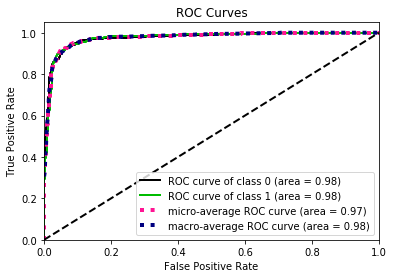

In [37]:
y_probas =  clf_logistic_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

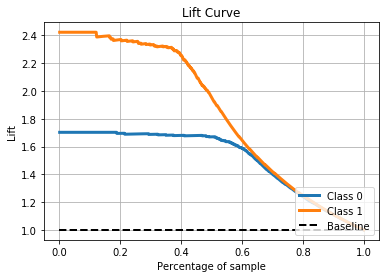

In [38]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## KNN

In [39]:
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring=custom_scorer)
grid_knn.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_knn.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_knn.best_params_)

print(" ")
print("Best estimator")
print (grid_knn.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_knn_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_knn_best.predict(X_test_scaled)
print("KNN : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("KNN : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("KNN : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9198797990823672
 
Best parameters
{'n_neighbors': 5, 'weights': 'distance'}
 
Best estimator
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')
 
cross-validation results
Below are the scores for each model run
[0.90738061 0.89869754 0.9        0.9317852  0.91001451]
 
Mean Accuracy and variance: 0.91 (+/- 0.02)
 
KNN : accuracy on test data is  89.57 %
 
KNN : Confusion Matrix
 
[[614  62]
 [ 58 417]]
 
KNN : Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       676
           1       0.87      0.88      0.87       475

   micro avg       0.90      0.90      0.90      1151
   macro avg       0.89      0.89      0.89      1151
weighted avg       0.90      0.90      0.90      1151

Average Misclassification cost on test data is  678


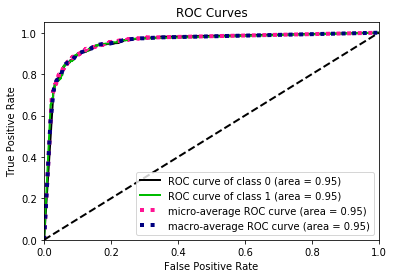

In [40]:
y_probas =  clf_knn_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

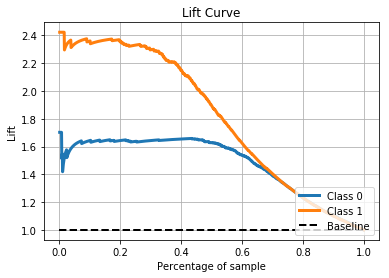

In [41]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Decision Tree

In [42]:
clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring=custom_scorer)
grid_DTree.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_DTree.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_DTree.best_params_)

print(" ")
print("Best estimator")
print (grid_DTree.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_Dtree_best.fit(X_train,y_train)
print(" ")
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Decision Tree : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Decision Tree : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Decision Tree : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9378833152367332
 
Best parameters
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 3}
 
Best estimator
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
 
cross-validation results
Below are the scores for each model run
[0.9406657  0.91316932 0.91884058 0.92597968 0.91727141]
 
Mean Accuracy and variance: 0.92 (+/- 0.02)
 
Decision Tree : accuracy on test data is  92.27 %
 
Decision Tree : Confusion Matrix
 
[[640  36]
 [ 53 422]]
 
Decision Tree : Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       676
           1       0.92      0.89      0.90       475


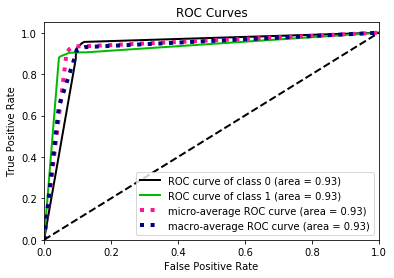

In [43]:
y_probas =  clf_Dtree_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

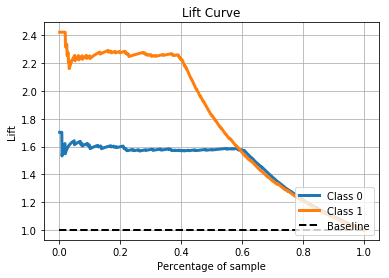

In [44]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## SVM

In [45]:
clf_SVC = svm.SVC(probability=True)

# Hyper parameter tuning using GridSearch
param_set = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1,2,3,4,5,10,100]},
                    {'kernel': ['linear'], 'C': [1,2,3,5,10,100]}]
grid_SVC = GridSearchCV(clf_SVC, param_grid = param_set, cv=5, scoring=custom_scorer)
grid_SVC.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_SVC.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_SVC.best_params_)

print(" ")
print("Best estimator")
print (grid_SVC.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_SVC_best = grid_SVC.best_estimator_
scores = cross_val_score(clf_SVC_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_SVC_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_SVC_best.predict(X_test_scaled)
print("SVC : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("SVC : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("SVC : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9341878518913528
 
Best parameters
{'C': 100, 'kernel': 'linear'}
 
Best estimator
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
 
cross-validation results
Below are the scores for each model run
[0.92040521 0.9146165  0.93333333 0.94629898 0.92888244]
 
Mean Accuracy and variance: 0.93 (+/- 0.02)
 
SVC : accuracy on test data is  92.27 %
 
SVC : Confusion Matrix
 
[[616  60]
 [ 29 446]]
 
SVC : Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       676
           1       0.88      0.94      0.91       475

   micro avg       0.92      0.92      0.92      1151
   macro avg       0.92      0.93      0.92      1151
weighted avg       0.92      0.92      0.92      1151

Average Miscla

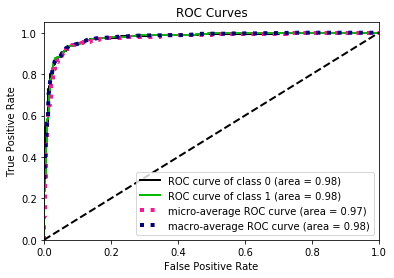

In [46]:
y_probas =  clf_SVC_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

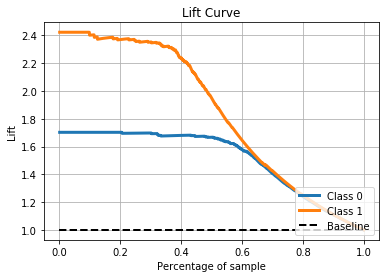

In [47]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Random Forest

In [48]:
start = time.process_time()
RF = ensemble.RandomForestClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': [3,10,20],
            'min_samples_split' :[4, 5,10],
            'n_estimators': [100, 250],
            'bootstrap':[True, False] ,
            'max_features':['auto', 'sqrt'],
            'n_jobs': [-1]
           }
grid_RF = GridSearchCV(RF, param_grid = param_set, cv=5, scoring=custom_scorer)
grid_RF.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_RF.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_RF.best_params_)

print(" ")
print("Best estimator")
print (grid_RF.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_RF_best = grid_RF.best_estimator_
scores = cross_val_score(clf_RF_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_RF_best.fit(X_train,y_train)
print(" ")
y_pred = clf_RF_best.predict(X_test_holdout)
print("Random Forest : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Random Forest : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Random Forest : Classification Report")
print(classification_report(y_test_holdout, y_pred))

print(" ")
print('Time Taken = ', time.process_time() - start)

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9520166521682478
 
Best parameters
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}
 
Best estimator
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.94934877 0.93487699 0.94347826 0.95791001 0.95936139]
 
Mean Accuracy and variance: 0.95 (+/- 0.02)
 
Random Forest : accuracy on test data is  95.74 %
 
Random Forest : Confusion Matrix
 
[[663  13]
 [ 36 439]]
 
Random Forest : Classification Report
              precision    recall  f1

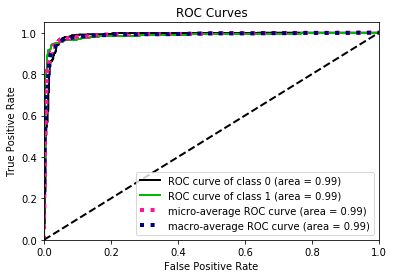

In [49]:
y_probas =  clf_RF_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

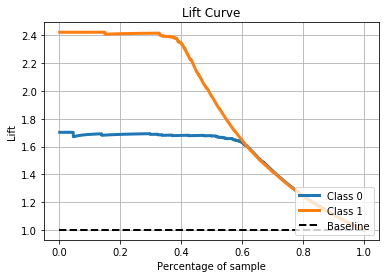

In [50]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## XGBoost

In [53]:
start = time.process_time()
XGB = xgboost.XGBClassifier(nthreads=-1)

a = stat.beta(10, 1)

# Hyper parameter tuning using GridSearch
param_set ={"n_estimators": stat.randint(3, 40),
            "max_depth": stat.randint(3, 40),
            "learning_rate": stat.uniform(0.05, 0.4),
            "colsample_bytree": a,
            "subsample": a,
            "gamma": stat.uniform(0, 10),
            'n_jobs':[-1]
           }

grid_XGB = RandomizedSearchCV(XGB, param_set, cv=5, scoring=custom_scorer)
grid_XGB.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", abs(grid_XGB.best_score_))

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_XGB.best_params_)

print(" ")
print("Best estimator")
print (grid_XGB.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_XGB_best = grid_XGB.best_estimator_
scores = cross_val_score(clf_XGB_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_XGB_best.fit(X_train,y_train)
print(" ")
y_pred = clf_XGB_best.predict(X_test_holdout)
print("XGBoost : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("XGBoost : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("XGBoost : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print('Time Taken = ', time.process_time() - start)

Best score achieved across all parameters:  0.9534628775230466
 
Best parameters
{'colsample_bytree': 0.8344532351264216, 'gamma': 1.8031720187997713, 'learning_rate': 0.3399075826989083, 'max_depth': 24, 'n_estimators': 13, 'n_jobs': -1, 'subsample': 0.9779856787507896}
 
Best estimator
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8344532351264216,
       gamma=1.8031720187997713, learning_rate=0.3399075826989083,
       max_delta_step=0, max_depth=24, min_child_weight=1, missing=None,
       n_estimators=13, n_jobs=-1, nthread=None, nthreads=-1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9779856787507896, verbosity=1)
 
cross-validation results
Below are the scores for each model run
[0.9536903  0.93632417 0.93913043 0.95065312 0.94920174]
 
Mean Accuracy and variance: 0.95 (+/- 0.01)
 
XGBoost : accuracy on te

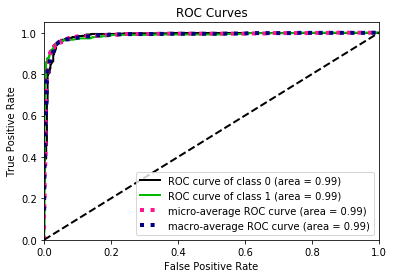

In [54]:
y_probas =  clf_XGB_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

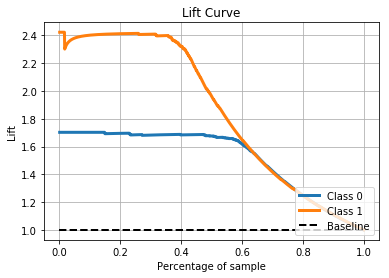

In [55]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()